In [1]:
# Numerai API
from numerapi import NumerAPI

# data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# stats
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error

# machine learning models
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# other
import gc
import json
from tqdm import trange
from itertools import product
import functools
import random
from timeit import default_timer
import re
import time
from pprint import pprint
from copy import deepcopy
from varname import nameof
from datetime import datetime

# save variables
import pickle
import joblib

# my utils
from utils import *

In [2]:
# invalid feature indices

# for f in INVALID_FEATURES:
#     i = FEATURES_L.index(f)
#     print(f'i = {i}, f = {f}')

l = list(range(10))
x = l[5
      :8]
print(x)

[5, 6, 7]


For each class:
- write code
- test that it works alone
- test that it works (when chained with previous classes)
- test that it works if passed to a GridSearchCV

In [3]:
X_COLS = FEATURES_S
COLUMNS = [ERA] + X_COLS + Y_COLS
Y_ALT = 'target_paul_v4_20'

df = pd.read_parquet('data/train.parquet', columns=COLUMNS)
df[ERA] = df[ERA].astype('int32')
df = df[df[ERA] <= 8]
dfnan = df.isna().any()
# print(df.dtypes[df.columns[-1]])
df[np.isnan(df)] = 0.5

params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 2**5,
    'colsample_bytree': 0.1,
    # 'device': 'gpu',
}

In [4]:
# compute_y_pred
model_0 = LGBMRegressor(**params)
model_0.fit(df[X_COLS], df[Y_TRUE])
y_pred_0 = model_0.predict(df[X_COLS])

model_1 = LGBMRegressor(**params)
model_1 = FeatureNeutralizer(model_1, n_features=10, alpha=1)
model_1.fit(df[X_COLS], df[Y_TRUE])
model_1.compute_y_pred(df[X_COLS])
y_pred_1 = model_1.y_pred
model_1.compute_y_linr(df[X_COLS], df[ERA])
y_linr = model_1.y_linr

y_neut_0 = model_1.predict(df[X_COLS], df[ERA])
y_neut_1 = y_pred_1 - y_linr

model_2 = LGBMRegressor(**params)
model_2 = FeatureNeutralizer(model_2, n_features=10, alpha=1)
model_2.fit(df[X_COLS], df[Y_TRUE])
y_neut_2 = model_2.predict(df[X_COLS], df[ERA])

In [5]:
X = df[X_COLS]
y_pred = y_pred_0
groups = np_(df[ERA])

df['y_pred'] = y_pred

b1 = pd.DataFrame(y_pred)
b2 = maybe_rank(b1, groups)
b3 = np_(b2)

b0 = pd.Series(y_pred)
b4 = b0.groupby(groups).apply(lambda x: x.rank(pct=True))

b5 = df['y_pred'].groupby(groups).apply(lambda x: x.rank(pct=True))

# b = np_(maybe_rank(pd.DataFrame(b), rank_b))

exposures = corr(X, y_pred, rank_a=groups, rank_b=groups)
riskiest = [(v, i) for i, v in enumerate(exposures)]
riskiest = sorted(riskiest, reverse=True)
riskiest = riskiest[0:10]
riskiest = [i for _, i in riskiest]

R = X.to_numpy()[:, riskiest]
df_Ry = pd.DataFrame(np.hstack((R, np.atleast_2d(y_pred).T)))
X_ = df_Ry[df_Ry.columns[0:-1]]
y_ = df_Ry[df_Ry.columns[-1]]
model = LinearRegression()
model.fit(X_, y_)
yp = model.predict(X_)
yi = model.intercept_
yl = yp - yi

In [6]:
# res = df_Ry.groupby(groups).apply(lambda x: x)

In [7]:
# Normal LightGBM
model_0 = LGBMRegressor(**params)
model_0.fit(df[X_COLS], df[Y_TRUE])
score_0 = model_0.score(df[X_COLS], df[Y_TRUE])

In [8]:
# Neutralize LightGBM, get_params
model_1 = LGBMRegressor(**params)
model_1 = FeatureNeutralizer(model_1, n_features=0, alpha=1)
model_1.get_params()

# Neutralize LightGBM, n_features = 0
model_1.fit(df[X_COLS], df[Y_TRUE])
score_1 = model_1.score(df[X_COLS], df[Y_TRUE], groups=df[ERA])

In [9]:
# Neutralize LightGBM, alpha = 0
model_2 = LGBMRegressor(**params)
model_2 = FeatureNeutralizer(model_2, n_features=10, alpha=0)
model_2.fit(df[X_COLS], df[Y_TRUE])
score_2 = model_2.score(df[X_COLS], df[Y_TRUE], df[ERA])

In [10]:
# Neutralize LightGBM, n_features = 50, alpha = 1
model_3 = LGBMRegressor(**params)
model_3 = FeatureNeutralizer(model_3, n_features=10, alpha=1)
model_3.fit(df[X_COLS], df[Y_TRUE])
score_3 = model_3.score(df[X_COLS], df[Y_TRUE], df[ERA])

y_pred = model_3.y_pred
y_linr = model_3.y_linr
y_neut_3a = y_pred - y_linr
y_neut_3b = model_3.predict(df[X_COLS], df[ERA])

0.5929209263008283


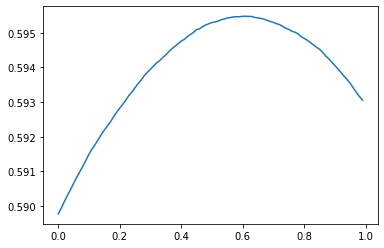

In [11]:
# Neutralize LightGBM, n_features = 50, alpha varying plot
al = np.arange(0, 1, 0.01)
cr = np.arange(0, 1, 0.01)

print(corr(df[Y_TRUE], y_neut_3a, rank_b=df[ERA]))

for i in range(len(al)):
    model_3.set_params(alpha=al[i])
    y_neut = model_3.predict(df[X_COLS], df[ERA])
    cr[i] = corr(df[Y_TRUE], y_neut, rank_b=df[ERA])

fig, ax = plt.subplots()
ax.plot(al, cr)

In [12]:
# Neutralize(MultiOutput)
model_4 = LGBMRegressor(**params)
model_4 = MultiTargetTrainer(model_4, targets=[0])
model_4 = FeatureNeutralizer(model_4, n_features=10, alpha=1)
model_4.fit(df[X_COLS], df[Y_COLS])
score_4 = model_4.score(df[X_COLS], df[Y_TRUE], df[ERA])

In [13]:
# Neutralize(MultiOutput(Era(Feature)))
model_5 = LGBMRegressor(**params)
# model_5 = FeatureSubsampler(model_5, n_features_per_group=0)
model_5 = EraSubsampler(model_5, n_subsamples=4)
model_5 = MultiTargetTrainer(model_5, targets=[0, 1, 5, 7])
model_5 = FeatureNeutralizer(model_5, n_features=10, alpha=0.7)
model_5.fit(df[X_COLS], df[Y_COLS], eras=df[ERA])
score_5 = model_5.score(df[X_COLS], df[Y_TRUE], df[ERA])